In [1]:
# Load required libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from plotnine import ggplot
import scipy
from scipy import sparse
import anndata as ad
import scanpy as sc
import scvelo as scv
scv.set_figure_params()

In [2]:
import sys

# Get the currently loaded modules
loaded_modules = {name: module for name, module in sys.modules.items() if module}

# Extract module names and versions
loaded_packages = {}
for name, module in loaded_modules.items():
    try:
        version = getattr(module, '__version__', None)
        if version:
            loaded_packages[name] = version
    except AttributeError:
        pass

# Print the loaded packages and their versions
print("Currently Loaded Packages and Versions:")
for name, version in loaded_packages.items():
    print(f"{name}: {version}")


Currently Loaded Packages and Versions:
re: 2.2.1
ipykernel._version: 6.28.0
json: 2.0.9
jupyter_client._version: 8.6.0
platform: 1.0.8
_ctypes: 1.1.0
ctypes: 1.1.0
zmq.sugar.version: 25.1.2
zmq.sugar: 25.1.2
zmq: 25.1.2
logging: 0.5.1.2
traitlets._version: 5.7.1
traitlets: 5.7.1
jupyter_core.version: 5.5.0
jupyter_core: 5.5.0
ipaddress: 1.0
zlib: 1.0
_curses: b'2.2'
socketserver: 0.4
argparse: 1.1
dateutil: 2.8.2
six: 1.16.0
_decimal: 1.70
decimal: 1.70
platformdirs.version: 3.10.0
platformdirs: 3.10.0
_csv: 1.0
csv: 1.0
jupyter_client: 8.6.0
ipykernel: 6.28.0
IPython.core.release: 8.20.0
executing.version: 0.8.3
executing: 0.8.3
pure_eval.version: 0.2.2
pure_eval: 0.2.2
stack_data.version: 0.2.0
stack_data: 0.2.0
pygments: 2.15.1
ptyprocess: 0.7.0
pexpect: 4.8.0
decorator: 5.1.1
wcwidth: 0.2.5
prompt_toolkit: 3.0.43
parso: 0.8.3
jedi: 0.18.1
urllib.request: 3.11
IPython: 8.20.0
comm: 0.2.1
psutil: 5.9.0
debugpy.public_api: 1.6.7
debugpy: 1.6.7
xmlrpc.client: 3.11
http.server: 0.6
pkg

In [12]:
def md39_buildAnndataFromStarCurr(path):
    """Generate an anndata object from the STAR aligner output folder"""
    # https://github.com/alexdobin/STAR/issues/774#issuecomment-850477636
    # Jason's modification: changed paths from raw/ to filtered/
    #path=path
    print('Start building anndata for ' + path)
    
    # Load Read Counts
    X = sc.read_mtx(path+'Gene/filtered/matrix.mtx')
    #print('Done creating adata')
    
    # Transpose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects
    X = X.X.transpose()

    # Load the 3 matrices containing Spliced, Unspliced and Ambigous reads
    mtxU = np.loadtxt(path+'Velocyto/filtered/unspliced.mtx', skiprows=3, delimiter=' ')
    mtxS = np.loadtxt(path+'Velocyto/filtered/spliced.mtx', skiprows=3, delimiter=' ')
    mtxA = np.loadtxt(path+'Velocyto/filtered/ambiguous.mtx', skiprows=3, delimiter=' ')
    #print('Done loading mtx files')
    
    # Extract sparse matrix shape informations from the third row
    shapeU = np.loadtxt(path+'Velocyto/filtered/unspliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeS = np.loadtxt(path+'Velocyto/filtered/spliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeA = np.loadtxt(path+'Velocyto/filtered/ambiguous.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)

    # Read the sparse matrix with csr_matrix((data, (row_ind, col_ind)), shape=(M, N))
    # Subract -1 to rows and cols index because csr_matrix expects a 0 based index
    # Traspose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects

    spliced = sparse.csr_matrix((mtxS[:,2], (mtxS[:,0]-1, mtxS[:,1]-1)), shape = shapeS).transpose()
    unspliced = sparse.csr_matrix((mtxU[:,2], (mtxU[:,0]-1, mtxU[:,1]-1)), shape = shapeU).transpose()
    ambiguous = sparse.csr_matrix((mtxA[:,2], (mtxA[:,0]-1, mtxA[:,1]-1)), shape = shapeA).transpose()
    #print('Done processing mtx files')
    
    # Load Genes and Cells identifiers
    obs = pd.read_csv(path+'Gene/filtered/barcodes.tsv',
                  header = None, index_col = 0)

    # Remove index column name to make it compliant with the anndata format
    obs.index.name = None

    var = pd.read_csv(path+'Gene/filtered/features.tsv', sep='\t',
                      names = ('gene_ids', 'feature_types'), index_col = 1)
  
    # Build AnnData object to be used with ScanPy and ScVelo
    adata = ad.AnnData(X = X, obs = obs, var = var,
                       layers = {'spliced': spliced, 'unspliced': unspliced, 'ambiguous': ambiguous})
    adata.var_names_make_unique()
    #print('Done assembling anndata')
    
    # Subset Cells based on STAR filtering
    #selected_barcodes = pd.read_csv(path+'GeneFull/filtered/barcodes.tsv', header = None)
    #adata = adata[selected_barcodes[0]]
    
    print('Finished building anndata for '+ path) 
    return adata.copy()

In [8]:
paths = glob.glob('../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/*/Solo.out/')
paths = paths + glob.glob('../starsolo_output/241118Lov_15pSer_day14_GEX/*/Solo.out/')
paths.sort()
paths

['../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220209Lov_D22-122035/Solo.out/',
 '../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220209Lov_D22-122037/Solo.out/',
 '../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220621Lov_D22-6366/Solo.out/',
 '../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220621Lov_D22-6367/Solo.out/',
 '../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220621Lov_D22-6368/Solo.out/',
 '../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220621Lov_D22-6369/Solo.out/',
 '../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220621Lov_D22-6390/Solo.out/',
 '../starsolo_output/241118Lov_15pSer_day14_GEX/241118Lov_D24-17752/Solo.out/',
 '../starsolo_output/241118Lov_15pSer_day14_GEX/241118Lov_D24-17753/Solo.out/',
 '../starsolo_output/241118Lov_15pSer_day14_GEX/241118Lov_D24-17754/Solo.out/',
 '../starsolo_output/241118Lov_15pSer_day14_GEX/241118Lov_D24-17755/Solo.out/',
 '../starsolo_output/241118Lov_15pSer_day14_GEX/24111

In [9]:
sample_id = [x.split('/')[3] for x in paths]
sample_name = ['AG1','AG3','AQ1','AQ2','AQ3','AQ4','AG2']+['P' + str(x+1) for x in range(8)]
sample_dict = {sample_id[i]: sample_name[i] for i in range(len(sample_id))}
sample_dict

{'220209Lov_D22-122035': 'AG1',
 '220209Lov_D22-122037': 'AG3',
 '220621Lov_D22-6366': 'AQ1',
 '220621Lov_D22-6367': 'AQ2',
 '220621Lov_D22-6368': 'AQ3',
 '220621Lov_D22-6369': 'AQ4',
 '220621Lov_D22-6390': 'AG2',
 '241118Lov_D24-17752': 'P1',
 '241118Lov_D24-17753': 'P2',
 '241118Lov_D24-17754': 'P3',
 '241118Lov_D24-17755': 'P4',
 '241118Lov_D24-17756': 'P5',
 '241118Lov_D24-17757': 'P6',
 '241118Lov_D24-17758': 'P7',
 '241118Lov_D24-17759': 'P8'}

In [14]:
adata_list = []
for curr_path in paths: 
    curr_sample_id = curr_path.split('/')[3] # third element
    curr_sample = sample_dict[curr_sample_id]
    if curr_sample in ['P' + str(x+1) for x in range(4,8)]:
        continue
    # print(curr_sample)
    adata = md39_buildAnndataFromStarCurr(curr_path)
    adata_list.append(adata)

Start building anndata for ../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220209Lov_D22-122035/Solo.out/
Finished building anndata for ../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220209Lov_D22-122035/Solo.out/
Start building anndata for ../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220209Lov_D22-122037/Solo.out/
Finished building anndata for ../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220209Lov_D22-122037/Solo.out/
Start building anndata for ../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220621Lov_D22-6366/Solo.out/
Finished building anndata for ../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220621Lov_D22-6366/Solo.out/
Start building anndata for ../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220621Lov_D22-6367/Solo.out/
Finished building anndata for ../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/220621Lov_D22-6367/Solo.out/
Start building anndata for ../starsolo_output/2022_AG_AQ_MD39_GC_day14_GEX_vMaster/2

In [20]:
samples = ['AG1','AG3','AQ1','AQ2','AQ3','AQ4','AG2']+['P' + str(x+1) for x in range(4)]
samples
adata = adata_list[0].concatenate(adata_list[1:],join="outer",batch_categories=samples,index_unique='_',)
adata

AnnData object with n_obs × n_vars = 167944 × 57186
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    layers: 'spliced', 'unspliced', 'ambiguous'

In [21]:
# to be consistant with seurat analysis 
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 30208 × 22618
    obs: 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'spliced', 'unspliced', 'ambiguous'

In [22]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


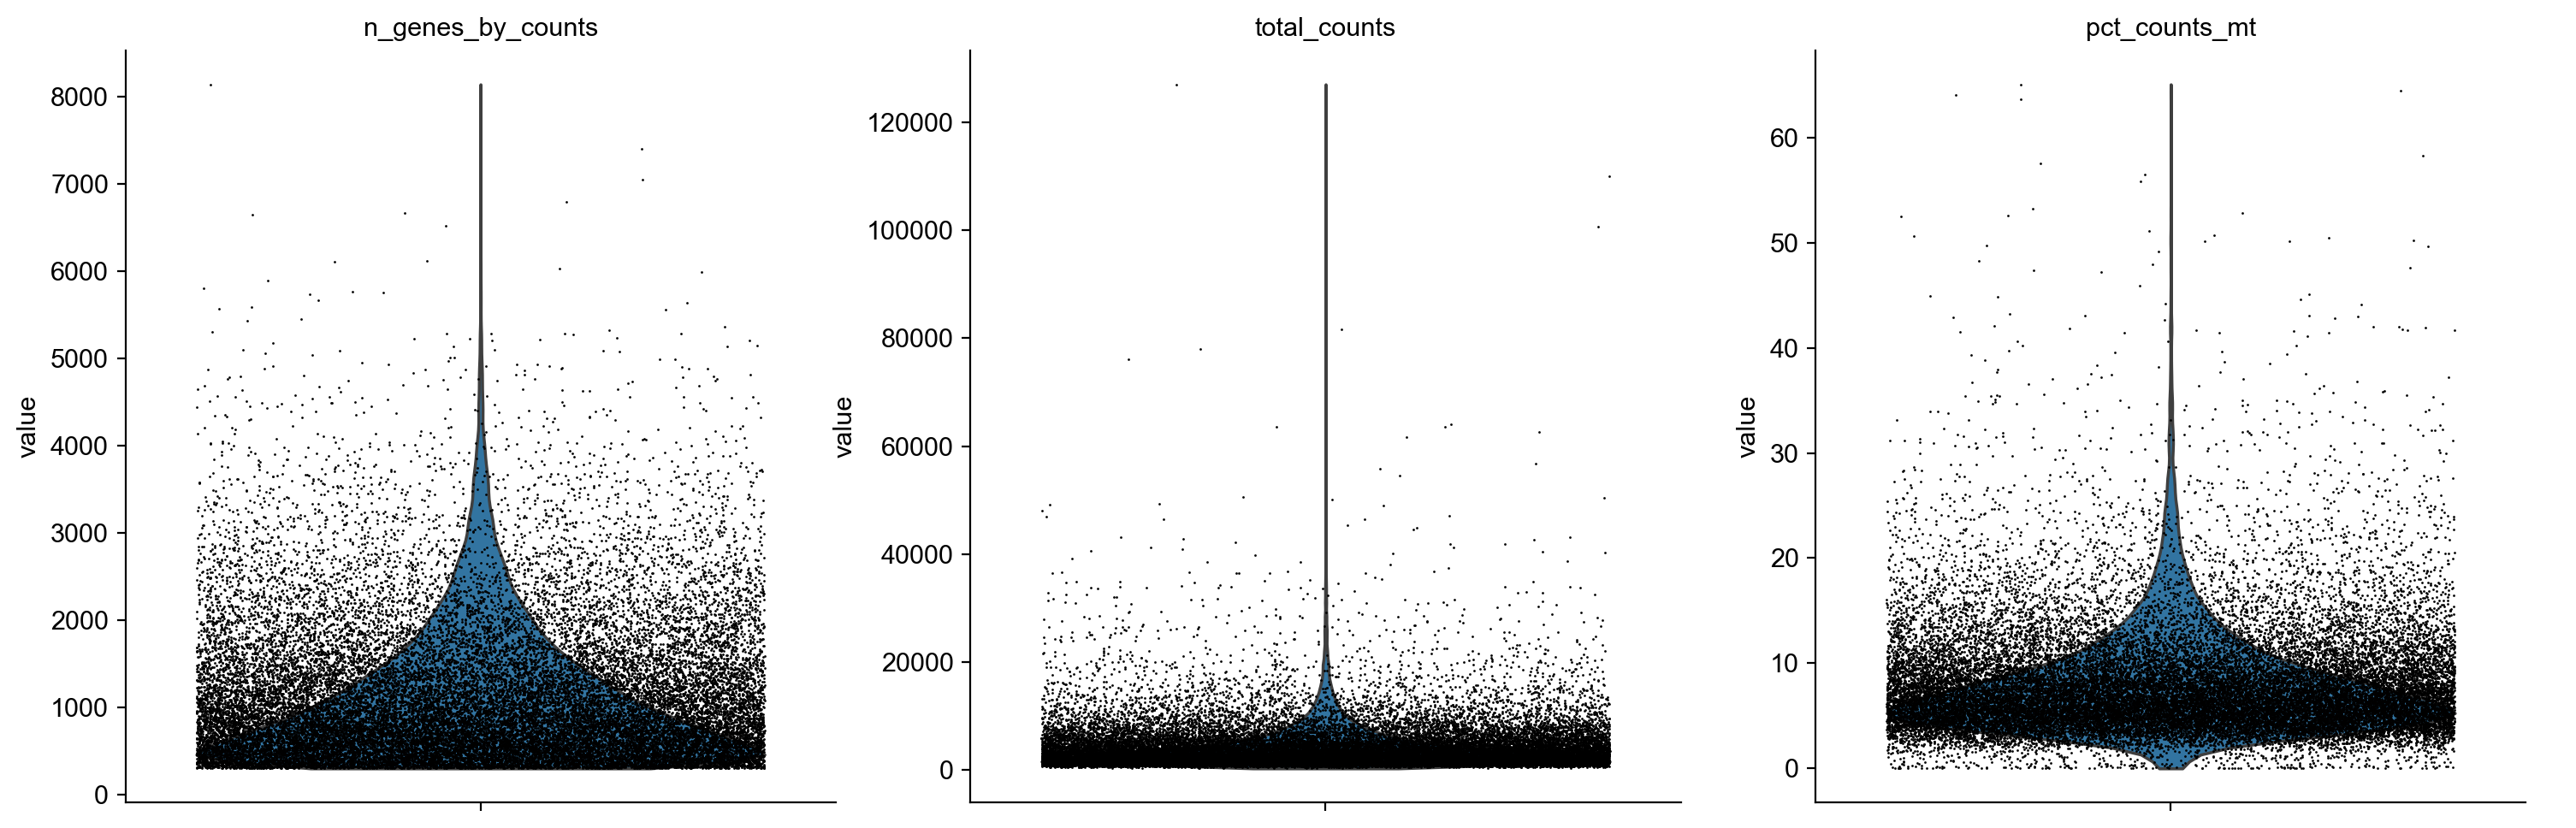

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [24]:
adata = adata[adata.obs.pct_counts_mt < 25, :]
adata

View of AnnData object with n_obs × n_vars = 29772 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'spliced', 'unspliced', 'ambiguous'

In [25]:
adata.obs['bc'] = adata.obs.index.str.split('_').str[0]
adata.obs['cell_id'] = adata.obs['batch'].astype(str) + '_' + adata.obs['bc']

In [26]:
adata.obs.head()

batch  n_genes  n_genes_by_counts  total_counts  \
AACCCGACCCCA_AG1   AG1     2401               2375       10110.0   
AATGCTTTACAG_AG1   AG1      675                675        2185.0   
AATTACGACCTT_AG1   AG1     1020               1016        9587.0   
ACAGCGGCGAGC_AG1   AG1     2063               2035       14649.0   
ACAGGGTGTACG_AG1   AG1     1715               1712        5891.0   

                  total_counts_mt  pct_counts_mt            bc  \
AACCCGACCCCA_AG1            654.0       6.468843  AACCCGACCCCA   
AATGCTTTACAG_AG1             73.0       3.340961  AATGCTTTACAG   
AATTACGACCTT_AG1            158.0       1.648065  AATTACGACCTT   
ACAGCGGCGAGC_AG1            657.0       4.484948  ACAGCGGCGAGC   
ACAGGGTGTACG_AG1            386.0       6.552368  ACAGGGTGTACG   

                           cell_id  
AACCCGACCCCA_AG1  AG1_AACCCGACCCCA  
AATGCTTTACAG_AG1  AG1_AATGCTTTACAG  
AATTACGACCTT_AG1  AG1_AATTACGACCTT  
ACAGCGGCGAGC_AG1  AG1_ACAGCGGCGAGC  
ACAGGGTGTACG_AG1  AG1_ACAGGGTGTACG

In [27]:
adata.write('anndata_object/00_RNA_velocity.h5ad', compression = 'gzip')

In [ ]:
# preprocessing 

In [4]:
adata = ad.read_h5ad('anndata_object/00_RNA_velocity.h5ad')
adata

AnnData object with n_obs × n_vars = 29772 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [5]:
# get metadata from seurat and remove doublets based on cell hashing
#srat_meta = pd.read_csv('seurat_object/00_cca_integrated_metadata.csv',sep=',',index_col=0)
srat_meta = pd.read_csv('seurat_object/00_harmony_metadata.csv',sep=',',index_col=0)
print(srat_meta.shape)
srat_meta.head()

(19537, 28)


orig.ident  nCount_RNA  nFeature_RNA           cell_id  \
AG1_AAAATTATCATT        AG1        1332           422  AG1_AAAATTATCATT   
AG1_GGGTGGCGCGTA        AG1        1918           341  AG1_GGGTGGCGCGTA   
AG1_TGTCCCGAGGGA        AG1        4700          1264  AG1_TGTCCCGAGGGA   
AG1_TTGTTAGTCCTA        AG1        4188          1012  AG1_TTGTTAGTCCTA   
AG3_AAAAACAGCGAC        AG3        1225           607  AG3_AAAAACAGCGAC   

                  nCount_HTO  nFeature_HTO             HTO_maxID  \
AG1_AAAATTATCATT         310             4  HTO3.CTTGCCGCATGTCAT   
AG1_GGGTGGCGCGTA          39             4  HTO2.GGTCGAGAGCATTCA   
AG1_TGTCCCGAGGGA         407             4  HTO2.GGTCGAGAGCATTCA   
AG1_TTGTTAGTCCTA         195             4  HTO2.GGTCGAGAGCATTCA   
AG3_AAAAACAGCGAC         105             4  HTO3.CTTGCCGCATGTCAT   

                          HTO_secondID  HTO_margin    HTO_classification  ...  \
AG1_AAAATTATCATT  HTO1.ACCCACCAGTAAGAC    2.355904  HTO3.CTTGCCGCATGTCAT  ...   
AG1_GGGTGGCGCGTA  HTO1.ACCCACCAGTAAGAC    0.996134  HTO2.GGTCGAGAGCATTCA  ...   
AG1_TGTCCCGAGGGA  HTO1.ACCCACCAGTAAGAC    3.222410  HTO2.GGTCGAGAGCATTCA  ...   
AG1_TTGTTAGTCCTA  HTO3.CTTGCCGCATGTCAT    2.505210  HTO2.GGTCGAGAGCATTCA  ...   
AG3_AAAAACAGCGAC  HTO2.GGTCGAGAGCATTCA    1.097962  HTO3.CTTGCCGCATGTCAT  ...   

                           group  mouse.id     UMAP1     UMAP2  \
AG1_AAAATTATCATT            SMNP  AG1_HTO3  2.522469 -3.140774   
AG1_GGGTGGCGCGTA            SMNP  AG1_HTO2 -1.879151 -1.702617   
AG1_TGTCCCGAGGGA            SMNP  AG1_HTO2  2.576538 -3.019667   
AG1_TTGTTAGTCCTA            SMNP  AG1_HTO2 -3.481525 -0.472330   
AG3_AAAAACAGCGAC  Alum-pSer/SMNP  AG3_HTO3  0.371185  3.709292   

                  RNA_snn_res.0.4  RNA_snn_res.0.6  RNA_snn_res.0.7  \
AG1_AAAATTATCATT                3                6                5   
AG1_GGGTGGCGCGTA                1                1                7   
AG1_TGTCCCGAGGGA                3                4                6   
AG1_TTGTTAGTCCTA                1                1                7   
AG3_AAAAACAGCGAC                5                5                4   

                  RNA_snn_res.0.8 RNA_snn_res.0.9 RNA_snn_res.1.1  
AG1_AAAATTATCATT                6               5               8  
AG1_GGGTGGCGCGTA                7               9              10  
AG1_TGTCCCGAGGGA                4               5               8  
AG1_TTGTTAGTCCTA                7               9              10  
AG3_AAAAACAGCGAC                5               8               9  

[5 rows x 28 columns]

In [6]:
filtered_adata = adata[adata.obs['cell_id'].isin(srat_meta.cell_id)]
filtered_adata.obs['array'] = filtered_adata.obs.batch
filtered_adata.obs['batch'] = filtered_adata.obs.batch.str[0:-1]
filtered_adata

AnnData object with n_obs × n_vars = 18116 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id', 'array'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [7]:
srat_meta['orig.ident'].value_counts()

orig.ident
AQ4    3918
P1     3458
AQ3    3328
AQ1    3038
AG3    2769
P2     2027
P4      763
AQ2     182
AG2      26
P3       24
AG1       4
Name: count, dtype: int64

In [8]:
filtered_adata.obs.batch.value_counts()

batch
AQ    10013
P      5484
AG     2619
Name: count, dtype: int64

In [9]:
filtered_adata.write('anndata_object/01_velocity_filtered.h5ad', compression = 'gzip')

In [48]:
adata = ad.read_h5ad('anndata_object/01_velocity_filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 18116 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id', 'array'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [71]:
# adata = filtered_adata
# adata

AnnData object with n_obs × n_vars = 18116 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id', 'array'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [49]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="batch")
adata.raw = adata # can go back with adata.raw.to_adata()


In [50]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")


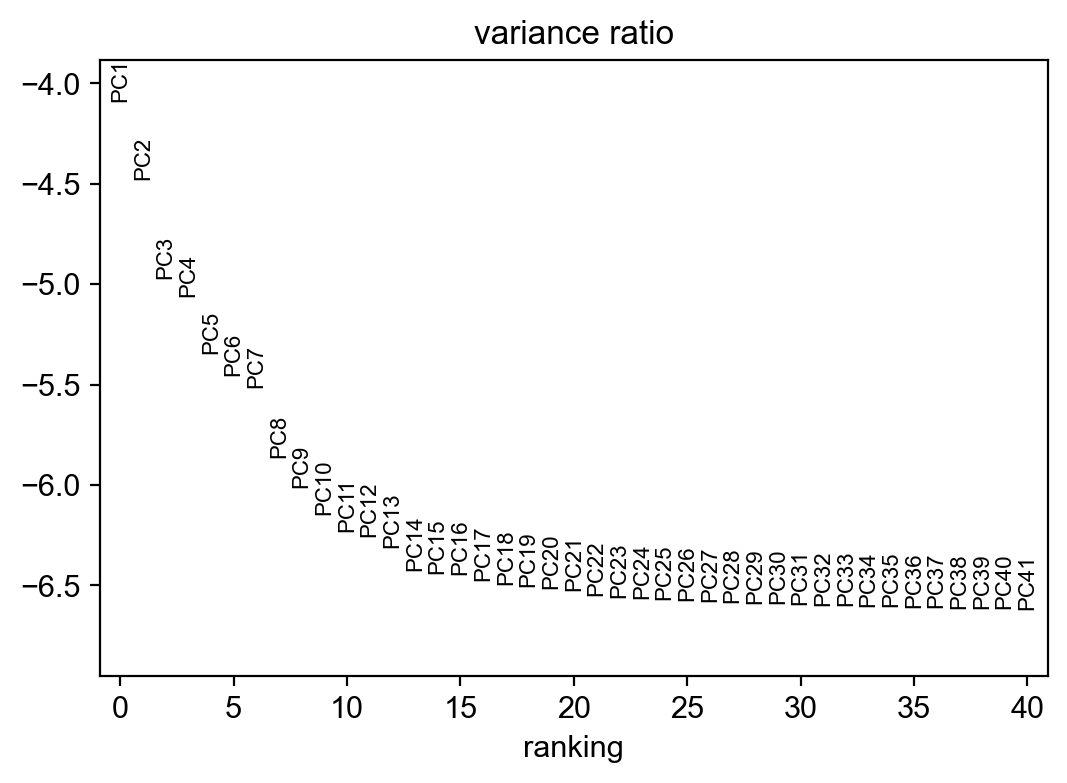

In [51]:
sc.pl.pca_variance_ratio(adata, n_pcs=40, log=True)


In [52]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20)
sc.tl.umap(adata,min_dist=0.3)


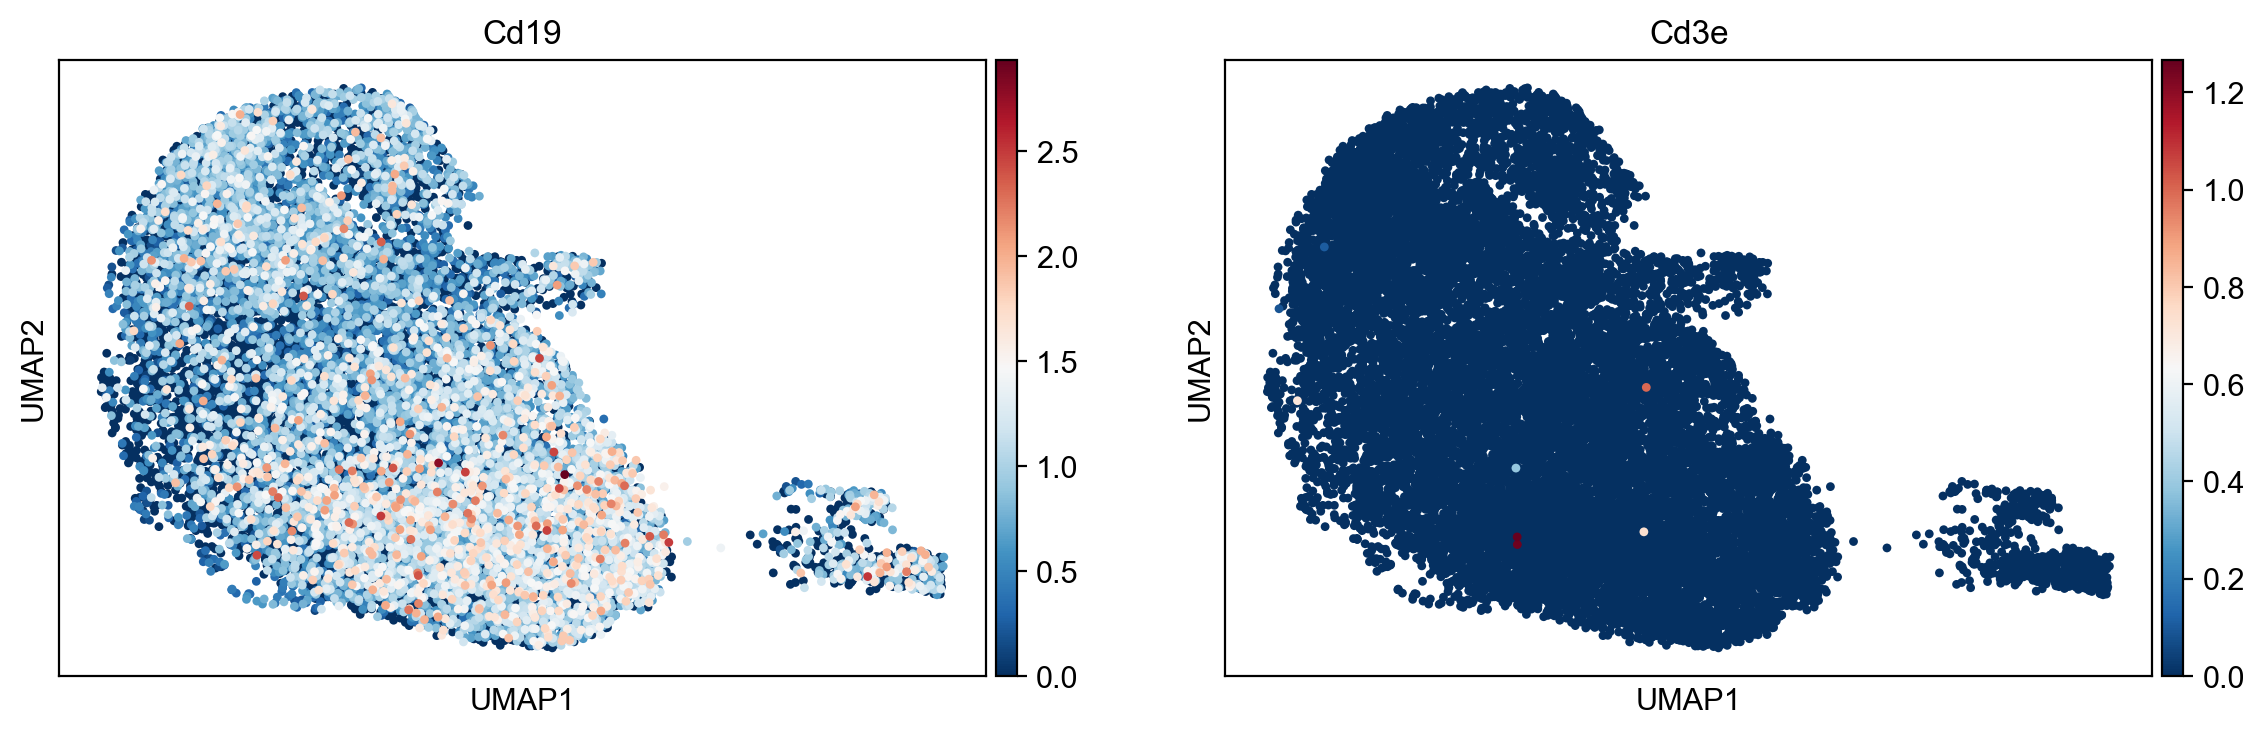

In [53]:
sc.pl.umap(adata,color=['Cd19','Cd3e'],size=40)


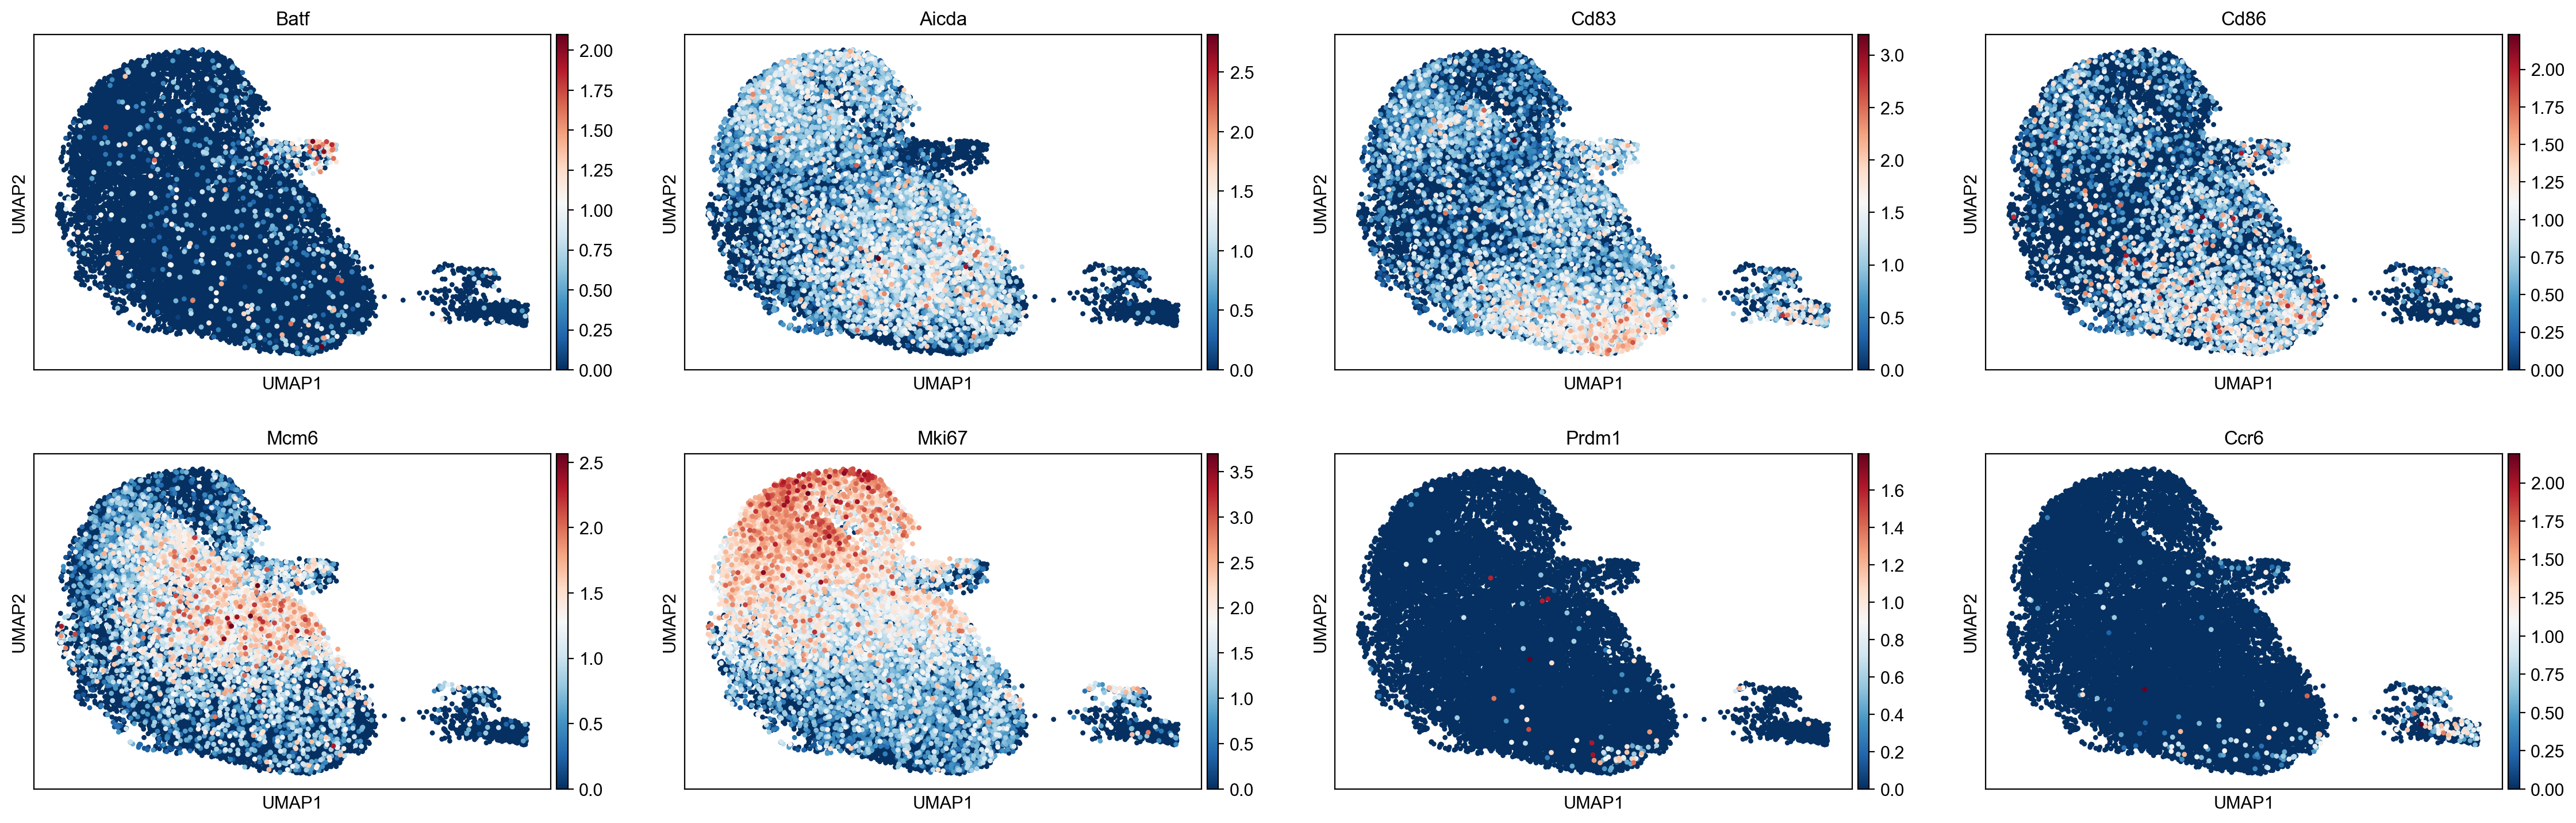

In [54]:
sc.pl.umap(adata,color=['Batf','Aicda','Cd83','Cd86','Mcm6','Mki67','Prdm1','Ccr6'],size=40)


In [17]:
sc.tl.leiden(adata,resolution=0.9,key_added = 'leiden0.9')
sc.tl.leiden(adata,resolution=1.1,key_added = 'leiden1.1')
adata

AnnData object with n_obs × n_vars = 18116 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id', 'array', 'leiden0.9', 'leiden1.1'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden0.9', 'leiden1.1'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'
    obsp: 'distances', 'connectivities'

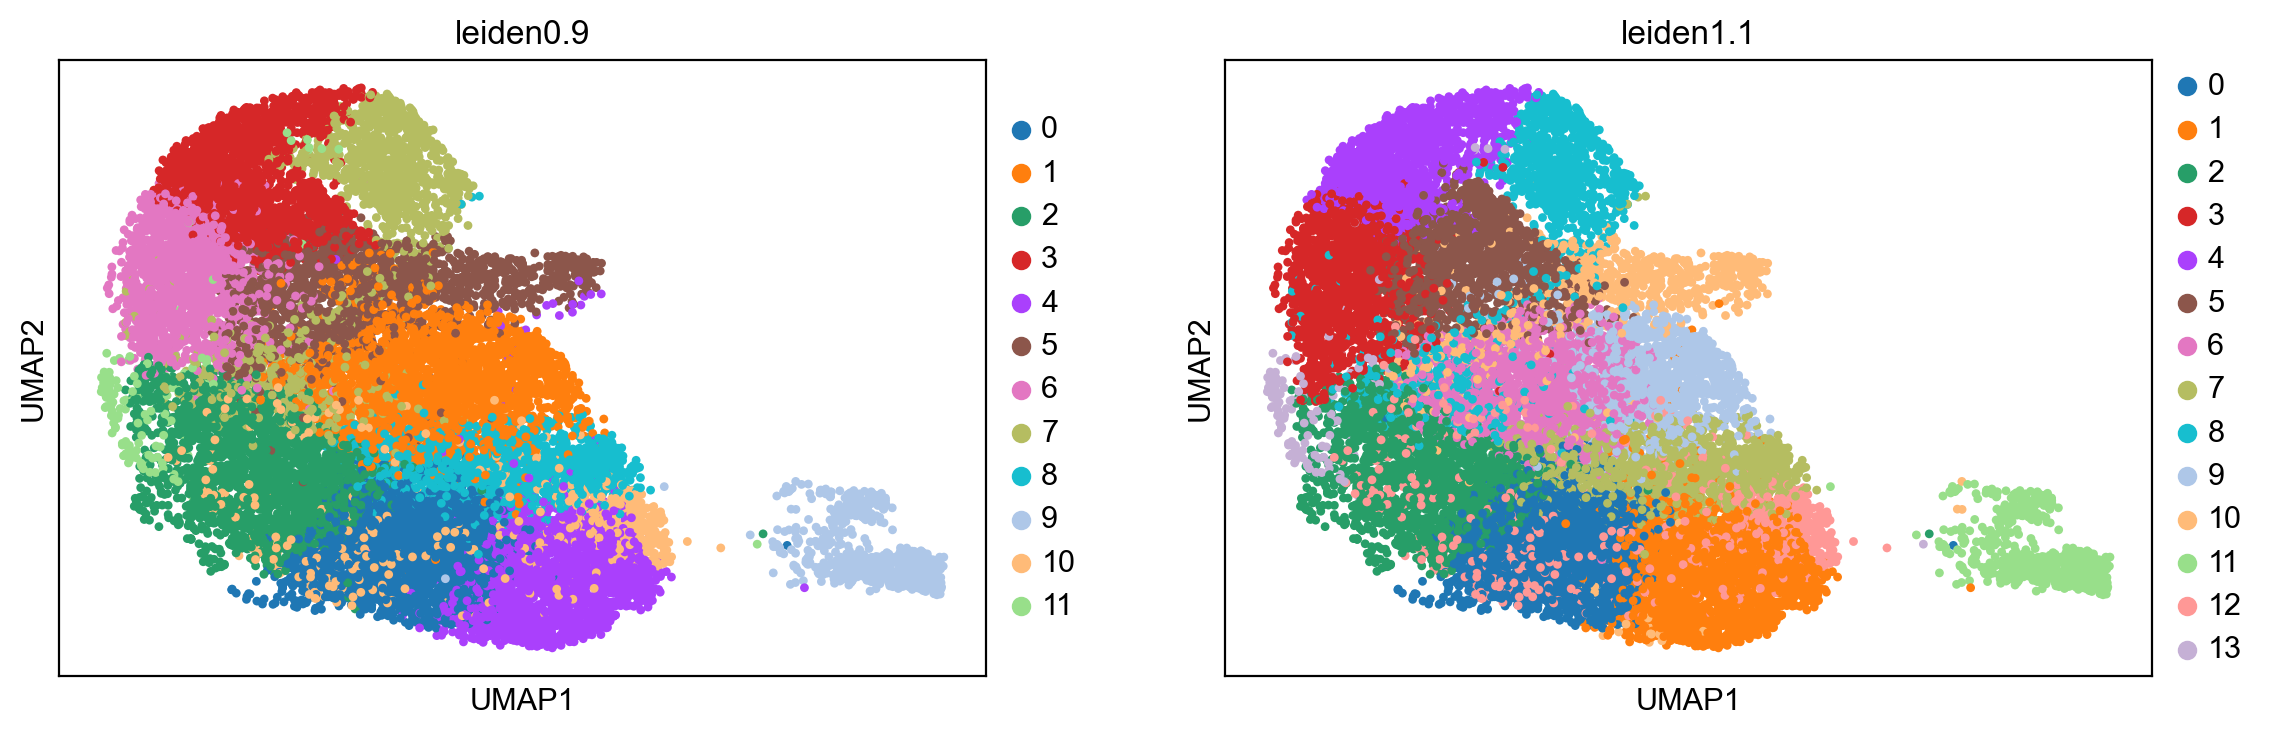

In [18]:
sc.pl.umap(adata,color=['leiden0.9','leiden1.1'],
           ncols=2,size=40)

In [55]:
adata.write('anndata_object/02_velocity_processed.h5ad', compression = 'gzip')

In [3]:
gc_meta = pd.read_csv('seurat_object/01_harmony_labeled.csv',sep=',',index_col=0)
print(gc_meta.shape)
matched = gc_meta[gc_meta['cell_id'].isin(adata.obs['cell_id'])]
print(matched.shape)
matched.head()

(19537, 29)
(18116, 29)


orig.ident  nCount_RNA  nFeature_RNA           cell_id  \
AG1_TGTCCCGAGGGA        AG1        4700          1264  AG1_TGTCCCGAGGGA   
AG1_TTGTTAGTCCTA        AG1        4188          1012  AG1_TTGTTAGTCCTA   
AG3_AAAAACAGCGAC        AG3        1225           607  AG3_AAAAACAGCGAC   
AG3_AAAAATCCTTGG        AG3        1989           630  AG3_AAAAATCCTTGG   
AG3_AAAAATGCTCCA        AG3        1359           383  AG3_AAAAATGCTCCA   

                  nCount_HTO  nFeature_HTO             HTO_maxID  \
AG1_TGTCCCGAGGGA         407             4  HTO2.GGTCGAGAGCATTCA   
AG1_TTGTTAGTCCTA         195             4  HTO2.GGTCGAGAGCATTCA   
AG3_AAAAACAGCGAC         105             4  HTO3.CTTGCCGCATGTCAT   
AG3_AAAAATCCTTGG         248             4  HTO1.ACCCACCAGTAAGAC   
AG3_AAAAATGCTCCA         145             4  HTO1.ACCCACCAGTAAGAC   

                          HTO_secondID  HTO_margin    HTO_classification  ...  \
AG1_TGTCCCGAGGGA  HTO1.ACCCACCAGTAAGAC    3.222410  HTO2.GGTCGAGAGCATTCA  ...   
AG1_TTGTTAGTCCTA  HTO3.CTTGCCGCATGTCAT    2.505210  HTO2.GGTCGAGAGCATTCA  ...   
AG3_AAAAACAGCGAC  HTO2.GGTCGAGAGCATTCA    1.097962  HTO3.CTTGCCGCATGTCAT  ...   
AG3_AAAAATCCTTGG  HTO2.GGTCGAGAGCATTCA    1.705996  HTO1.ACCCACCAGTAAGAC  ...   
AG3_AAAAATGCTCCA  HTO2.GGTCGAGAGCATTCA    0.794928  HTO1.ACCCACCAGTAAGAC  ...   

                  mouse.id     UMAP1     UMAP2 RNA_snn_res.0.4  \
AG1_TGTCCCGAGGGA  AG1_HTO2 -2.001104  4.132259               3   
AG1_TTGTTAGTCCTA  AG1_HTO2  3.788568 -0.532041               1   
AG3_AAAAACAGCGAC  AG3_HTO3 -1.651474 -3.134243               5   
AG3_AAAAATCCTTGG  AG3_HTO1 -1.015900 -0.401344               0   
AG3_AAAAATGCTCCA  AG3_HTO1  1.092157  0.428525               4   

                  RNA_snn_res.0.6  RNA_snn_res.0.7  RNA_snn_res.0.8  \
AG1_TGTCCCGAGGGA                4                6                4   
AG1_TTGTTAGTCCTA                1                7                7   
AG3_AAAAACAGCGAC                5                4                5   
AG3_AAAAATCCTTGG                2                0                1   
AG3_AAAAATGCTCCA                3                3                3   

                  RNA_snn_res.0.9 RNA_snn_res.1.1 phenocluster  
AG1_TGTCCCGAGGGA                5               8           C3  
AG1_TTGTTAGTCCTA                9              10           C6  
AG3_AAAAACAGCGAC                8               9           C4  
AG3_AAAAATCCTTGG                1               0           C5  
AG3_AAAAATGCTCCA                4               4           C6  

[5 rows x 29 columns]

In [4]:
matched['bc'] = matched.cell_id.str.split('_').str[-1]
matched['idx'] = matched.bc +'_' +matched['orig.ident']
matched.set_index('idx',inplace=True)
matched.index.name=None
meta = matched.loc[:,['mouse.id','group','phenocluster']]

In [5]:
meta.head()

mouse.id           group phenocluster
TGTCCCGAGGGA_AG1  AG1_HTO2            SMNP           C3
TTGTTAGTCCTA_AG1  AG1_HTO2            SMNP           C6
AAAAACAGCGAC_AG3  AG3_HTO3  Alum-pSer/SMNP           C4
AAAAATCCTTGG_AG3  AG3_HTO1  Alum-pSer/SMNP           C5
AAAAATGCTCCA_AG3  AG3_HTO1  Alum-pSer/SMNP           C6

In [2]:
adata = ad.read_h5ad('anndata_object/02_velocity_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 18116 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id', 'array'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [6]:
# add seurat UMAP coord to anndata 
umap_coords = matched[['UMAP1', 'UMAP2']].values
adata.obsm['X_seurat'] = umap_coords
adata.obs = adata.obs.join(meta)

In [7]:
adata

AnnData object with n_obs × n_vars = 18116 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id', 'array', 'mouse.id', 'group', 'phenocluster'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_seurat'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [8]:
scv.pp.moments(adata, n_pcs=20, n_neighbors=30)
scv.tl.recover_dynamics(adata,n_jobs=32)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata,n_jobs=32)
adata

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:23) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 10/10 cores)


  0%|          | 0/181 [00:00<?, ?gene/s]

    finished (0:02:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:22) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/10 cores)


  0%|          | 0/18116 [00:00<?, ?cells/s]

    finished (0:00:25) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


AnnData object with n_obs × n_vars = 18116 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id', 'array', 'mouse.id', 'group', 'phenocluster', 'n_counts', 'velocity_self_transition'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'X_seurat'
    varm: 'PCs', 'loss'
    layers: 'ambiguous', 'counts',

In [10]:
adata.write('anndata_object/03_dynamic_model.h5ad', compression = 'gzip')

In [2]:
adata = ad.read_h5ad('anndata_object/03_dynamic_model.h5ad')
adata

AnnData object with n_obs × n_vars = 18116 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id', 'array', 'mouse.id', 'group', 'phenocluster', 'n_counts', 'velocity_self_transition'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'phenocluster_colors', 'recover_dynamics', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_seurat', 'X_umap', 'velocity_seurat'
    varm: 'PCs',

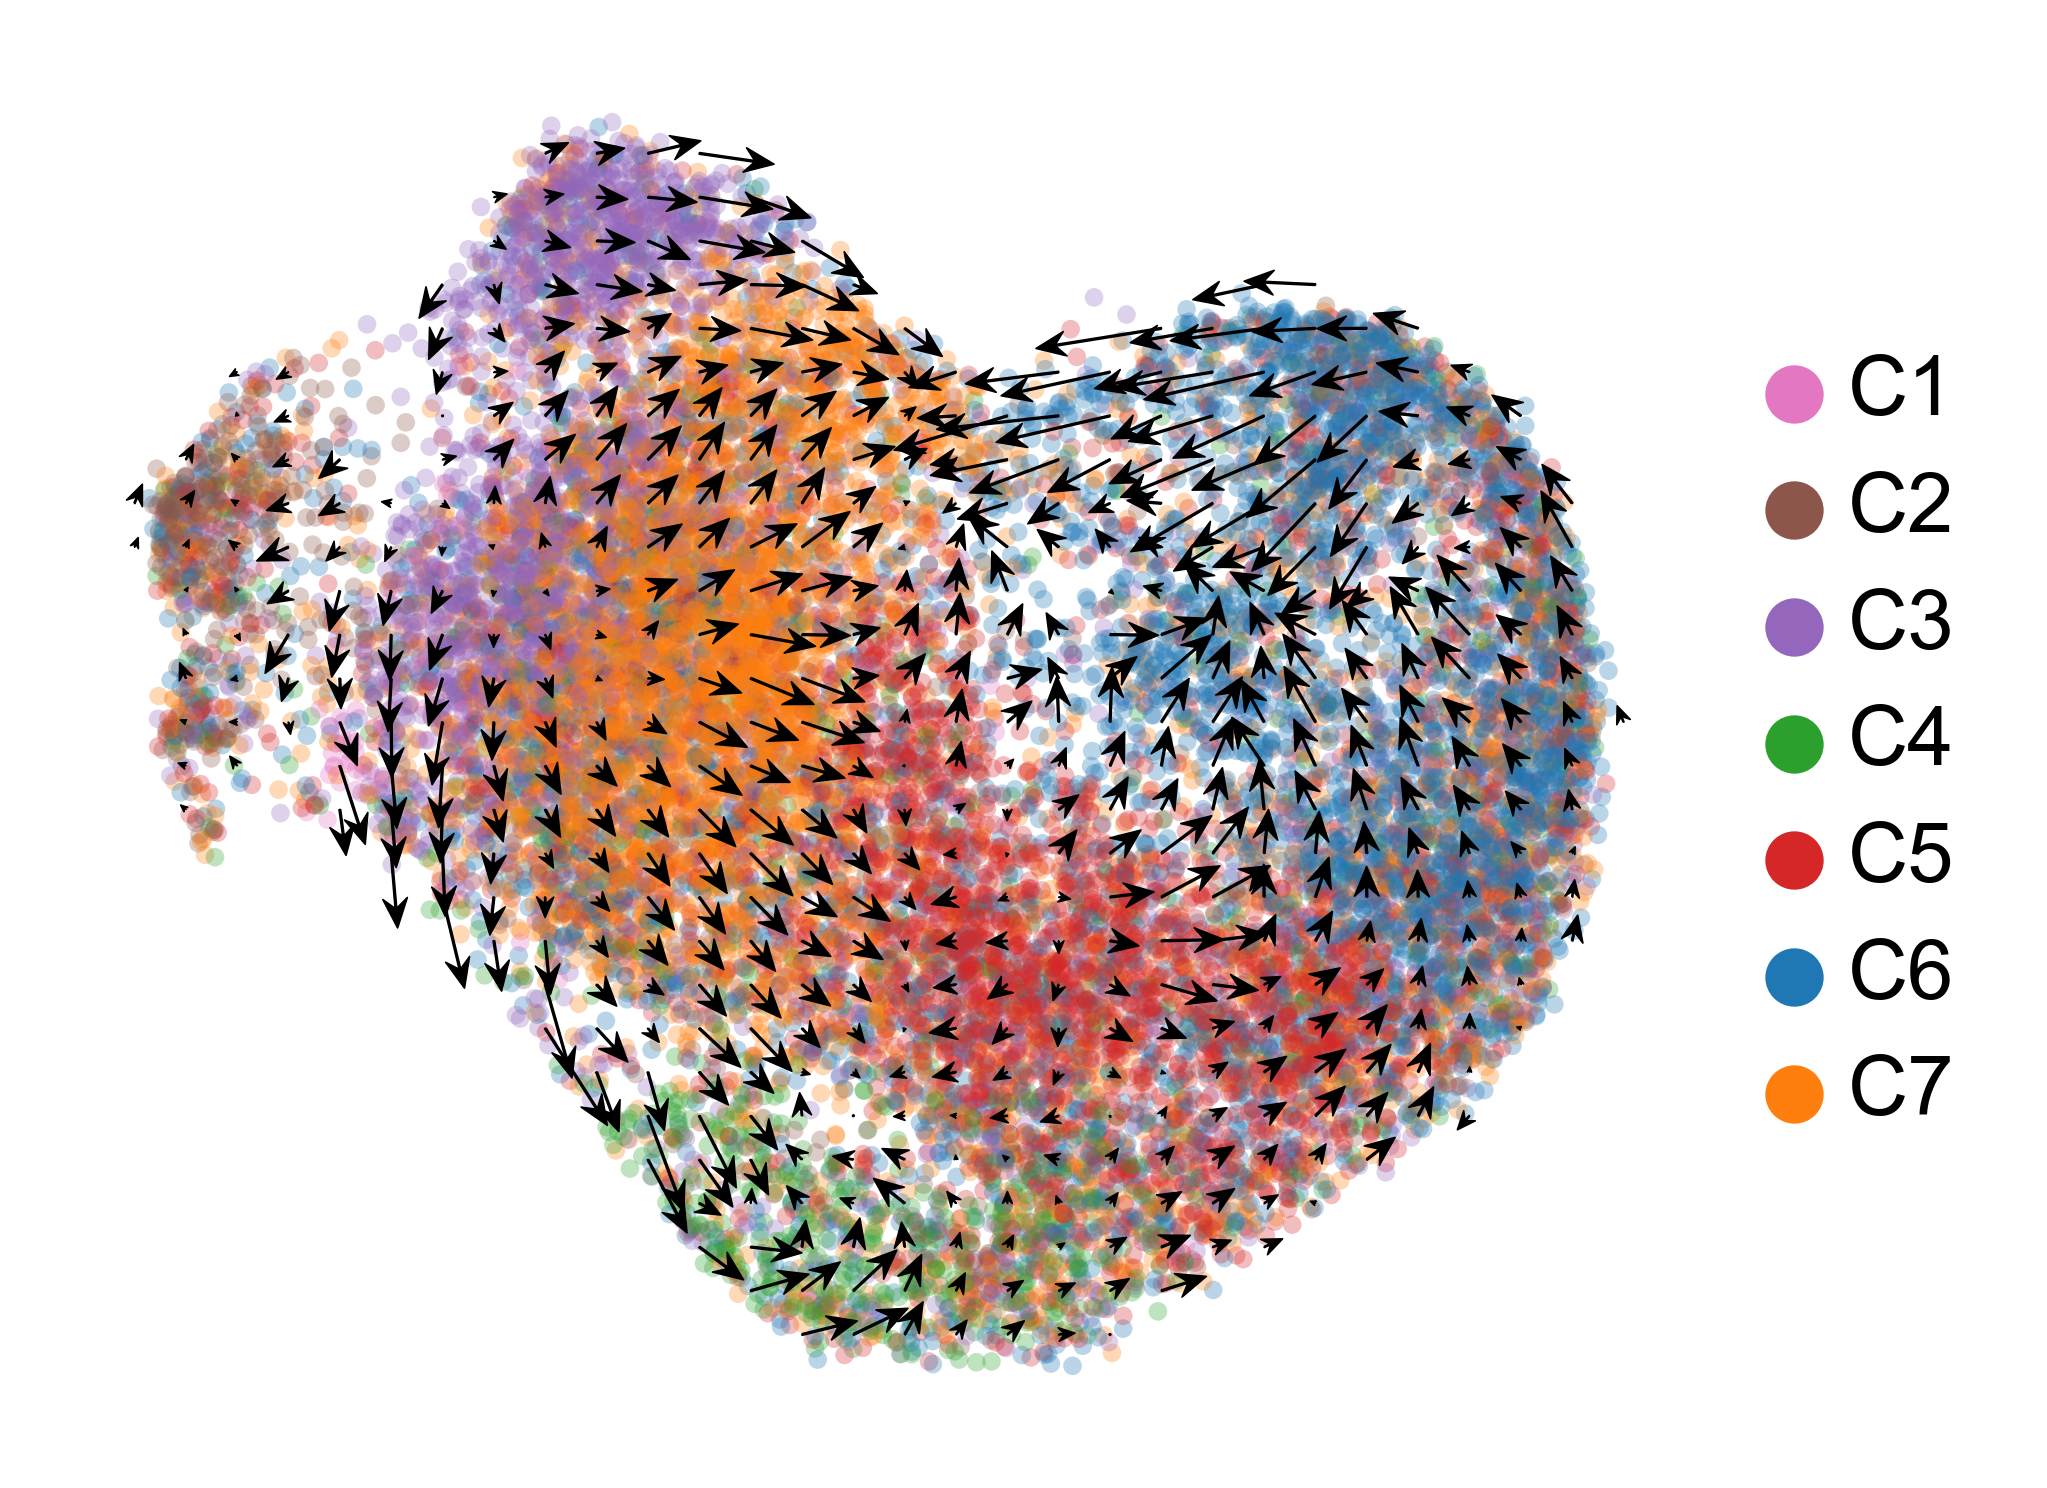

In [3]:
my_pal = ['#e377c2','#8c564b','#9467bd','#2ca02c','#d62728','#1f77b4','#ff7f0e']
scv.pl.velocity_embedding_grid(adata, basis='X_seurat',color='phenocluster',
                               arrow_length=2.5,min_mass=10,density=0.6,arrow_size=3,arrow_color='black',
                               legend_loc='right margin',legend_fontsize=10,legend_align_text=True,
                               figsize=(3.5,3),dpi=300,title='',palette=my_pal,alpha=0.3, size=20)

In [28]:
adata.obs[['UAMP1','UMAP2']] = adata.obsm['X_seurat']

In [29]:
adata

AnnData object with n_obs × n_vars = 18116 × 22618
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'bc', 'cell_id', 'array', 'mouse.id', 'group', 'phenocluster', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'UAMP1', 'UMAP2'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'phenocluster